In [1]:
%matplotlib inline

import math

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

##  Helpers

In [2]:
from enum import IntEnum

class MagSpin(IntEnum):
    DOWN = -1
    RANDOM = 0
    UP = 1

In [3]:
def initialstate(N: int, aDir: MagSpin):    
    ''' generates a random spin configuration for initial condition'''
    assert isinstance(aDir, MagSpin), f"Expected Direction, got {type(direction)}"
    
    if aDir == MagSpin.RANDOM:
        return np.random.choice([-1, 1], size=(1, N))
    else:
        return aDir.value*np.ones(shape=(1,N), dtype=int) 

In [4]:
def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    #Config is the NxN spin matrix configuration    
    #In each iteration NxN updates
    
    for i in range(N): # give every position(atom) a potential chance
        b = np.random.randint(0, N) # pick poistion(atom) to flip
        s =  config[0,b] # retrive old status of spin
        
        nb = config[0,(b+1)%N] + config[0,(b-1)%N] # calculate cost with wrap
        cost = 2*s*nb

        # make flip decision 
        if cost < 0:
            s *= -1 # flip the spin
        elif rand() < np.exp(-cost*beta): # importance sampling against Bolztman distribution which is proporitonal to exp(-1* energe level/kT), beta is = 1/kT 
            s *= -1 # flip the spin
        # else s = s # don't flip

        # write back new state
        config[0,b] = s 

    return config

In [5]:
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(N):
        S = config[0,i]
        nb = config[0,(i+1)%N] + config[0,(i-1)%N]
        energy += -nb*S
    return energy/2.    #Divide by 2 to avoid multiple counting

def calcMag(config):
    '''Magnetization of a given configuration'''
    #magnetiation is just sum of all spins \sum_{i} S_i
    return np.sum(config)

## Parameters

In [6]:
## change the parameter below if you want to simulate a smaller system
nt      = 2**4        # number of temperature points
N       = 2**6        # size of the lattice, N

t_star, t_end = .2, 1.0   #tempresture low and high

eqSteps = 2**10       # number of MC steps for equilibration
mcSteps = 2**10       # number of MC sweeps for calculation

n1, n2  = 1.0/(mcSteps*N*1), 1.0/(mcSteps*mcSteps*N*1)

## Initilization Status grid

In [7]:
T=np.linspace(t_star, t_end, nt) # starting, ending, num t steps

Energy         = np.zeros(nt)
Magnetization  = np.zeros(nt)
SpecificHeat   = np.zeros(nt)
Susceptibility = np.zeros(nt)

##  Simulation

In [9]:
print("Starting!!")

for m in range(nt): #m is the temperature index
    print("On temp", m, "of length", nt)

    config = initialstate(N, MagSpin.UP)
    iT=1.0/T[m]; iT2=iT*iT; # beta = 1/(k_B*T)

    for l in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves
        if l%50==0: print("in mcmove",l)

    #Calculate quantities post equilibriation
    E1 = M1 = E2 = M2 = 0
    for i in range(mcSteps):
        mcmove(config, iT)
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation
        if i%50==0: print("in mcstep",i,"e=",Ene)

        E1 = E1 + Ene                 #Cumulative energy
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene

        Energy[m]         = n1*E1     #Weighing for MC averages
        Magnetization[m]  = n1*M1
        SpecificHeat[m]   = (n1*E2 - n2*E1*E1)*iT2
        Susceptibility[m] = (n1*M2 - n2*M1*M1)*iT2

Starting!!
On temp 0 of length 16
in mcmove 0
in mcmove 50
in mcmove 100
in mcmove 150
in mcmove 200
in mcmove 250
in mcmove 300
in mcmove 350
in mcmove 400
in mcmove 450
in mcmove 500
in mcmove 550
in mcmove 600
in mcmove 650
in mcmove 700
in mcmove 750
in mcmove 800
in mcmove 850
in mcmove 900
in mcmove 950
in mcmove 1000
in mcstep 0 e= -64.0
in mcstep 50 e= -64.0
in mcstep 100 e= -64.0
in mcstep 150 e= -64.0
in mcstep 200 e= -64.0
in mcstep 250 e= -64.0
in mcstep 300 e= -64.0
in mcstep 350 e= -64.0
in mcstep 400 e= -64.0
in mcstep 450 e= -64.0
in mcstep 500 e= -64.0
in mcstep 550 e= -64.0
in mcstep 600 e= -64.0
in mcstep 650 e= -64.0
in mcstep 700 e= -64.0
in mcstep 750 e= -64.0
in mcstep 800 e= -64.0
in mcstep 850 e= -64.0
in mcstep 900 e= -64.0
in mcstep 950 e= -64.0
in mcstep 1000 e= -64.0
On temp 1 of length 16
in mcmove 0
in mcmove 50
in mcmove 100
in mcmove 150
in mcmove 200
in mcmove 250
in mcmove 300
in mcmove 350
in mcmove 400
in mcmove 450
in mcmove 500
in mcmove 550
in mc

## Visulizaiton 

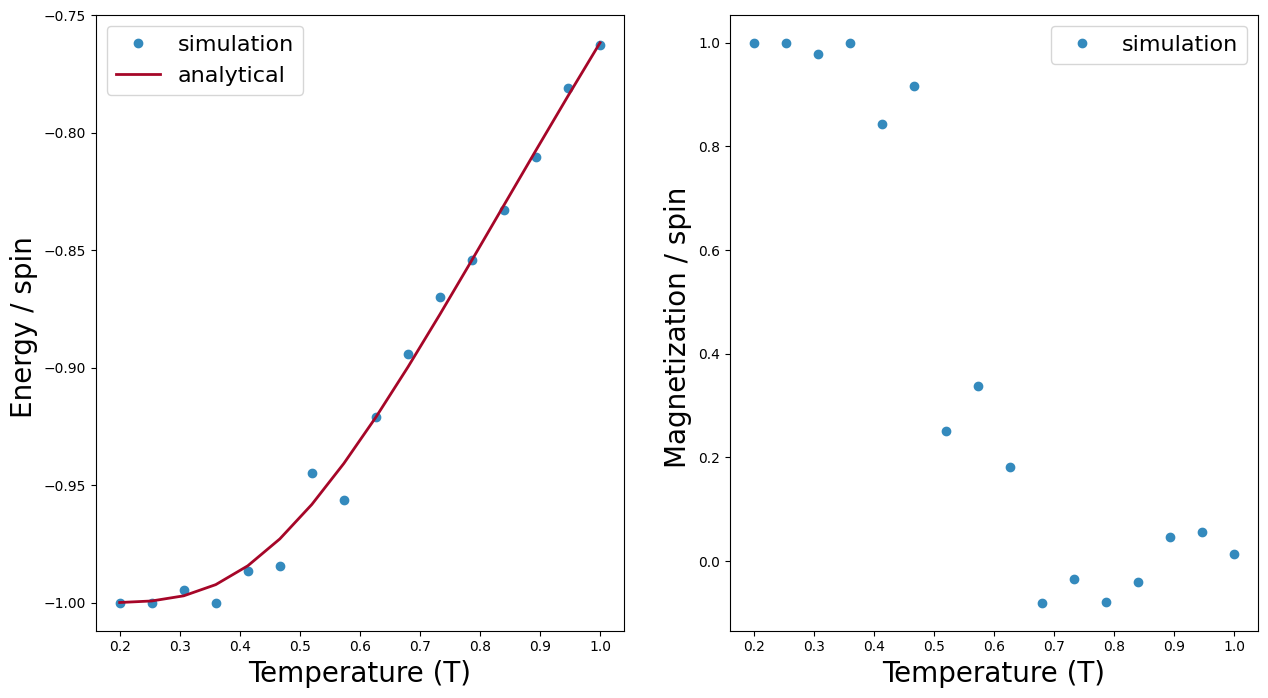

In [10]:
f = plt.figure(figsize=(15, 8)); # plot the calculated values

sp =  f.add_subplot(1, 2, 1 );
plt.plot(T, Energy, 'o', color="#348ABD", label='simulation');
plt.plot(T, -np.tanh(1.0/T), color="#A60628", lw=2,label='analytical')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy / spin ", fontsize=20); plt.legend(fontsize=16)


sp =  f.add_subplot(1, 2, 2 );
plt.plot(T, Magnetization, 'o', color="#348ABD", label='simulation');
#plt.plot(T, (crazy func from book), color="#A60628", lw=2,label='analytical')
plt.xlabel("Temperature (T)", fontsize=20); #plt.ylim([-10, -2])
plt.ylabel("Magnetization / spin ", fontsize=20);  plt.legend(fontsize=16)
plt.show()